# Building an AI agent with Strands Agents SDK

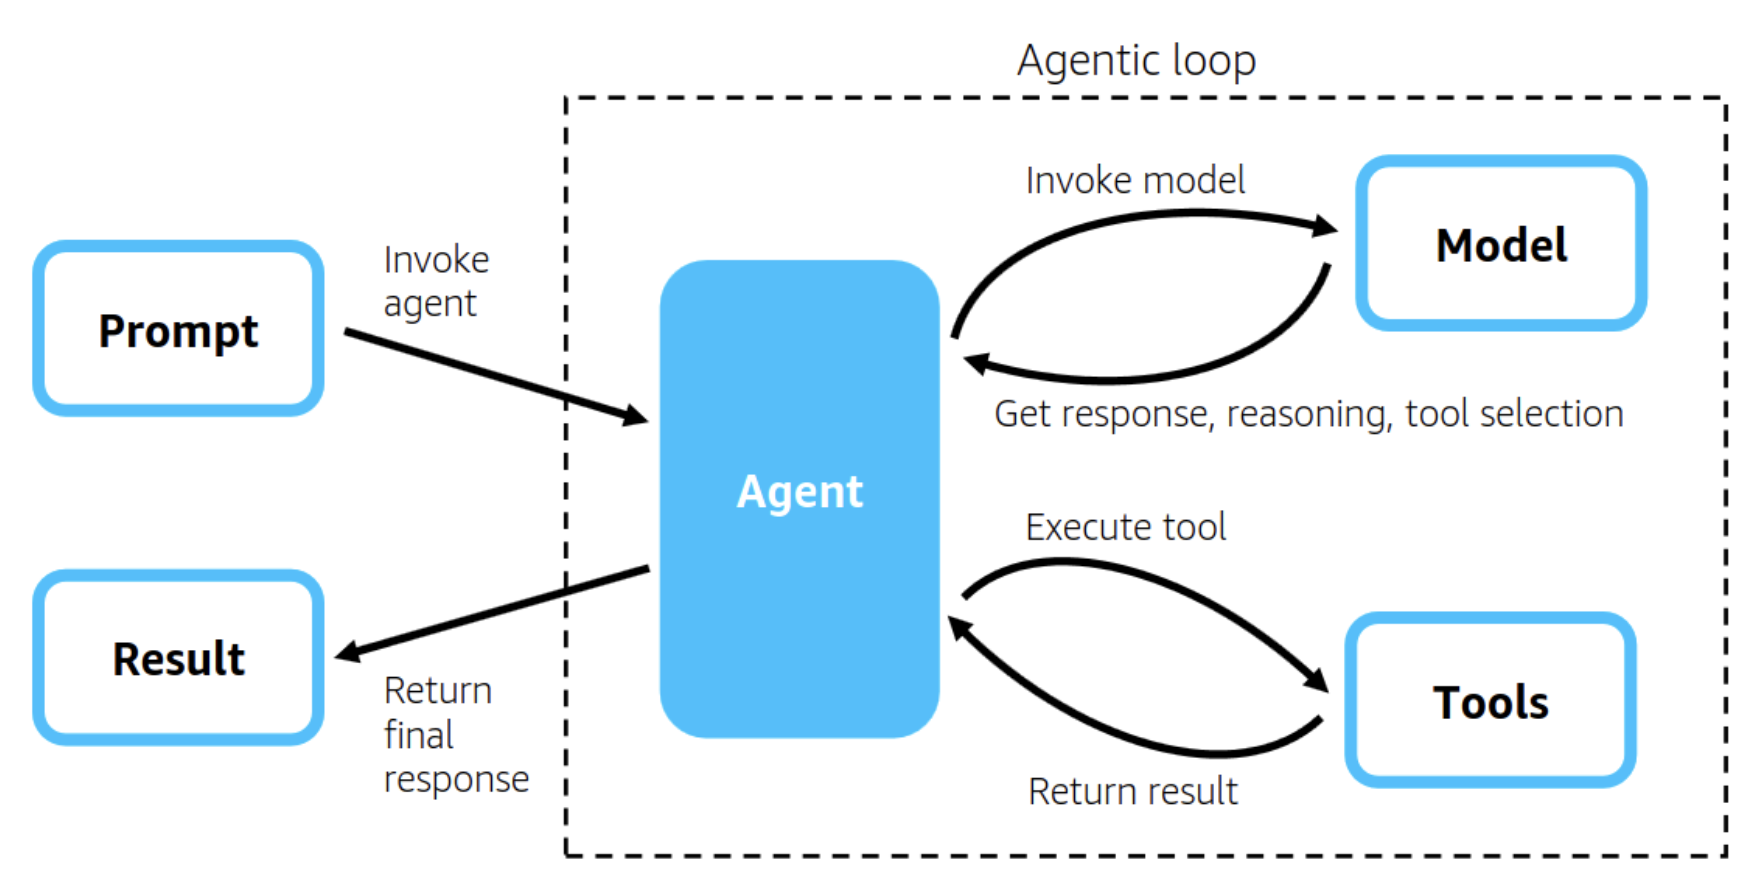

Building an AI agent with Strands Agents SDK is a straightforward process that centers around three fundamental components: a model, tools, and a prompt. To create an agent, developers first need to define these elements in their code. The model can be selected from various supported options, including Amazon Bedrock models with tool use and streaming capabilities, Anthropic's Claude model family, Ollama for local development, or other providers through LiteLLM. For tools, developers can choose from thousands of published Model Context Protocol (MCP) servers or utilize Strands' 20+ pre-built example tools for tasks like file manipulation, API requests, and AWS API interactions. Any Python function can be transformed into a tool using the Strands @tool decorator. The prompt consists of both a natural language prompt defining the agent's task and a system prompt providing general instructions and desired behavior. Once these components are defined, the agent operates in a loop, interacting with its model and tools until the task is completed. The Strands agentic loop leverages the advanced capabilities of modern LLMs to reason, plan, and select tools appropriately. To learn more about Strands Agents, head over to the announcement blog.

In this notebook, we will focus on how to build a Strands Agent.

# A model-driven approach to building AI agents in just a few lines of code

Strands Agents is a simple yet powerful SDK that takes a model-driven approach to building and running AI agents. From simple conversational assistants to complex autonomous workflows, from local development to production deployment, Strands Agents scales with your needs.<br/><br/>
This notebook demonstrates how to leverage the **Strands Agents SDK and Tools** to generate and execute automated Python code across a diverse range of tasks.

### Configure the Model for Strands Agents

<div class="alert alert-block alert-info">
	⚠️ <b>Important:</b> ⚠️</br> To use <b>Amazon SageMaker AI</b>, make sure you've deployed the model according to <code>0-setup/2-setup-sagemaker-endpoint.ipynb</code> before proceeding.
</div>

In [ ]:
from strands.models.sagemaker import SageMakerAIModel
from strands.models.bedrock import BedrockModel

provider = "BEDROCK"  

match provider:
    case "BEDROCK":
        # Using Claude 3.7 Sonnet from Bedrock
        model = BedrockModel(model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0")
        
    case "SAGEMAKER":
        # Load the stored endpoint name only when needed
        %store -r SAGEMAKER_ENDPOINT_NAME
        print(f"Endpoint name: {SAGEMAKER_ENDPOINT_NAME}")
        
        # Using Qwen3 from our endpoint in SageMaker AI
        model = SageMakerAIModel(
            endpoint_config={"endpoint_name": SAGEMAKER_ENDPOINT_NAME},
            payload_config={"max_tokens": 1024*5, "stream": True}
        )

In [ ]:
from strands import Agent

agent = Agent(model)
agent("What are AI Agents? Provide a concise answer.")

# Use Case 1: Web Scraping with a few lines of code
Uses `requests` and `BeautifulSoup` to scrape article titles and links from Hacker News, saving results to a CSV file.


In [ ]:
from strands_tools import python_repl, file_write , http_request
from strands import Agent
import os
from datetime import datetime

os.environ["BYPASS_TOOL_CONSENT"] = "true"

today = datetime.now().strftime("%Y-%m-%d")
prompt = """
Get the titles and the links of the top 10 articles from the webpage https://news.ycombinator.com/news . Then, write the results as a CSV file named `news-{date}.csv`.
"""

agent = Agent(model, tools=[http_request, file_write])
response = agent(prompt.format(date=today))

# Use Case 2: Stock Price Analysis  
Downloads historical stock data, calculates moving averages, key financial metrics, and buy/sell signals with visualizations and logging for Apple Inc. using `yfinance` and `matplotlib`.


In [ ]:
from strands_tools import python_repl
from strands import Agent, tool
import os

os.environ["BYPASS_TOOL_CONSENT"] = "true"
os.environ["PYTHON_REPL_INTERACTIVE"] = "False"

system_prompt = """
You are a financial analyst. Provide following charts:
- Plot 20-days moving average of closing prices for the past one year.
- Plot daily return rate comparison against S&P500 for the same period.

Also, compute following two metrics of the stock:
  - Volatility of the return rates

Use `yfinance` module to retrive the historical data. Use your python code interpreter in non-interactive mode only.
"""

agent = Agent(tools=[python_repl],
              system_prompt=system_prompt,
              model=model)

response = agent("Amazon")

# Use Case 3: City Weather Data Collection and Storage
Fetch detailed weather information by city and date/time from a public weather source, extracts key weather metrics, and stores them in DynamoDB for historical analysis.

In [ ]:
from strands_tools import use_aws, http_request
from strands import Agent, tool
import os

os.environ["BYPASS_TOOL_CONSENT"] = "true"

system_prompt = """
You are a weather data agent. Your job is to fetch weather details for a given city and date/time by searching publicly available weather information on the web.
[Instructions]
- Use HTTP GET to query a public weather website or API (e.g., https://wttr.in) with city and date parameters.
- Extract weather details such as temperature, conditions, humidity, wind speed, and date/time from the response.
- Save these weather details into a DynamoDB table named "CityWeatherData" in us-west-2.
  - Use 'City' as the partition key and 'DateTime' as the sort key.
  - Store other extracted weather details as attributes.
- If live data is unavailable or blocked, simulate realistic weather data for testing.
"""

example_url = """
Example: To get weather in San Francisco for today, query:
https://wttr.in/San+Francisco?format=j1
This returns JSON with weather details.
"""

agent = Agent(
    model=model,
    tools=[use_aws, http_request],
    system_prompt=f"{system_prompt} {example_url}",
)

response = agent("Get the weather details for New York City and save to DynamoDB.")

# Use Case 4: DataFrame Manipulation with pandas  
Creates a sample DataFrame, adds computed columns, filters rows based on conditions, and groups data with aggregation, showcasing pandas capabilities.


In [ ]:
from strands import Agent
from strands_tools import python_repl
import os

os.environ["PYTHON_REPL_INTERACTIVE"] = "False"

agent = Agent(
    model=model,
    tools=[python_repl]
)

prompt = """
Write a Python script using the pandas library that performs the following tasks:

- Create a sample DataFrame with the columns: 'Name', 'Age', and 'Salary'.
- Add a new column named 'Bonus' that is 10% of the corresponding 'Salary' value.
- Filter the DataFrame to include only rows where the 'Age' is greater than 30.
- Group the data by age brackets (e.g., 20s, 30s, 40s) and calculate the average 'Salary' and 'Bonus' for each group.

Execute the python script and show the output.

Requirements:
- Include clear inline comments to explain the logic.
- Add a docstring for the function, describing its purpose, parameters, and return value.
- Provide an example of how to use the function.
- List any external libraries that need to be installed with pip (if any).
- Include brief documentation describing how the code works and how to run it.
"""

response = agent(prompt)

# Use Case 5: Multi-agent scenario

## Financial Advisory System with AWS Bedrock Models

Let us create a financial advisory service which uses three specialized AI agents, each 
optimized with specific LLM models, tools, and prompts to address different 
customer financial needs effectively.
<br/><br/><br/>
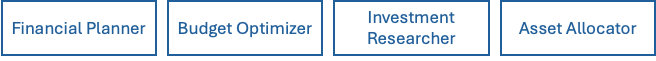
<br/>
Strands Agents provides multiple options to orchstrate these specialized agents.

In [ ]:
# Create specialized agents

from strands import Agent, tool
from strands.models.bedrock import BedrockModel

# Investment Research Assistant
model_research = BedrockModel(model_id="us.amazon.nova-pro-v1:0")
investment_researcher = Agent(
    name="investment_researcher",
    model=model_research,
    system_prompt="""
    You are a financial research analyst who helps users explore various investment opportunities. 
    You specialize in providing insights into stocks, ETFs, mutual funds, bonds, and other instruments.
    You also highlight key market trends, risk factors, and historical performance.
    Your goal is to equip users with comprehensive, objective information to support their investment decisions.
    """,
)


# Budget Optimizer Assistant
model_budget = BedrockModel(model_id="us.amazon.nova-lite-v1:0")
budget_optimizer = Agent(
    name="budget_optimizer",
    model=model_budget,
    system_prompt="""
    You are a smart budgeting assistant who helps users manage and optimize their monthly expenses.
    You analyze income, spending patterns, and savings goals, and suggest personalized recommendations 
    to cut unnecessary costs and improve savings. Your goal is to help users maintain a healthy financial balance.
    """,
)


# Financial Planner Assistant
model_planner = BedrockModel(model_id="us.amazon.nova-micro-v1:0")
financial_planner = Agent(
    name="financial_planner",
    model=model_planner,
    system_prompt="""
    You are a certified financial advisor bot who helps users create customized financial plans 
    based on their goals, income, age, and risk tolerance. 
    You guide them through budgeting, saving, debt management, insurance, and retirement planning.
    Your goal is to provide practical, step-by-step advice to help users achieve financial stability and growth.
    """,
)

# Asset Allocator
model_allocator = BedrockModel(model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0")
asset_allocator = Agent(
    name="asset_allocator",
    model=model_allocator,
    system_prompt="""
    You are an asset allocator. Based on the financial needs of the users,
    advise optimized asset allocation strategies.
    """,
)

#### Agents as Tools

"Agents as Tools" is an architectural pattern in AI systems where specialized AI agents are wrapped as callable functions (tools) that can be used by other agents. This creates a hierarchical structure where:
<br/>
1. **A primary "orchestrator" agent** handles user interaction and determines which specialized agent to call
2. **Specialized "tool agents"** perform domain-specific tasks when called by the orchestrator
<br/>This approach mimics human team dynamics, where a manager coordinates specialists, each bringing unique expertise to solve complex problems. Rather than a single agent trying to handle everything, tasks are delegated to the most appropriate specialized agent.
<br/><br/>
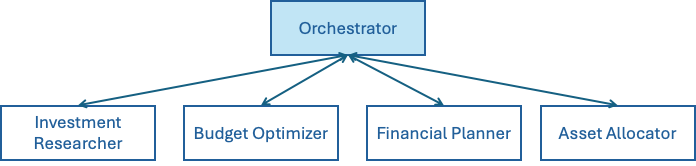



In [ ]:
# Use agents as tools
from strands import Agent

# Define orchestrator system prompt with clear tool selection guidance
MAIN_SYSTEM_PROMPT = """
You are a manager who works with specialized agents, who helps customers to set up their financial plans.
Use followings tools:
* financial_planner_assistant: Analyze the customer's needs and define financial goals.
* asset_allocator_assistant: Find out suggested asset allocation strategy.
* budget_optimizer_assistant: Optimize customer's spending and savings.
* investment_researcher_assistant: Recommend investable assets for the customer.
Always select the most appropriate tool based on the user's query.
"""

# Make the agents as tools.
@tool
def investment_researcher_assistant(query: str) -> str:
    return investment_researcher(query).message

@tool
def budget_optimizer_assistant(query: str) -> str:
    return budget_optimizer(query).message

@tool
def financial_planner_assistant(query: str) -> str:
    return financial_planner(query).message


@tool
def asset_allocator_assistant(query: str) -> str:
    return asset_allocator(query).message

# Strands Agents SDK allows easy integration of agent tools
orchestrator = Agent(name = "orchestrator",
                     model=model,
                     system_prompt=MAIN_SYSTEM_PROMPT,
                     tools=[investment_researcher_assistant,
                            budget_optimizer_assistant,
                            financial_planner_assistant,
                            asset_allocator_assistant])

orchestrator(
    """
    I'm 30 years old, earning around $6,000 per month. 
    I have some student loans and moderate savings.
    I want to understand how I can better manage my monthly budget, 
    explore investment options, and build a solid long-term financial plan 
    for buying a house and retiring early. Can you help?
    """
)

#### Swarm Multi-agent Pattern

A Swarm is a collaborative agent orchestration system where multiple agents work together as a team to solve complex tasks. Unlike traditional sequential or hierarchical multi-agent systems, a Swarm enables autonomous coordination between agents with shared context and working memory.


* **Self-organizing agent teams** with shared working memory
* **Tool-based coordination** between agents
* **Autonomous agent collaboration** without central control
* **Dynamic task distribution** based on agent capabilities
* **Collective intelligence** through shared context
* **Multi-modal input support** for handling text, images, and other content types
<br/>

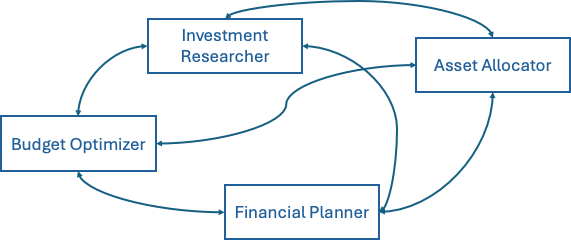


In [ ]:
from strands.multiagent import Swarm

financial_planner_swarm = Swarm(
    [investment_researcher, budget_optimizer, financial_planner, asset_allocator],
    max_handoffs=20,
    max_iterations=20,
    execution_timeout=900.0,  # 15 minutes
    node_timeout=300.0,       # 5 minutes per agent
    repetitive_handoff_detection_window=8,  # There must be >= 3 unique agents in the last 8 handoffs
    repetitive_handoff_min_unique_agents=4
)


In [ ]:
result = financial_planner_swarm(
"""
    I'm 30 years old, earning around $6,000 per month. 
    I have some student loans and moderate savings.
    I want to understand how I can better manage my monthly budget, 
    explore investment options, and build a solid long-term financial plan 
    for buying a house and retiring early. Can you help?
"""
)

# Access the final result
print(f"Status: {result.status}")
print(f"Node history: {[node.node_id for node in result.node_history]}")

# Use Case 6: MCP Integration - AWS Solutions Architect Agent with Documentation Querying and Diagram Generation

## 1.  Query AWS documentation (via an MCP server).
## 2.  Generate architectural diagrams (via another MCP server).


In [ ]:
from mcp import StdioServerParameters, stdio_client
from strands import Agent
from strands.models import BedrockModel
from strands.tools.mcp import MCPClient
from IPython.display import Image, display # Import for displaying images
import os # To check if the file exists
# It's good practice to import AgentResult if you know that's what's returned
# from strands.types import AgentResult # Or wherever it's defined in your strands version

aws_docs_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.aws-documentation-mcp-server@latest"]
        )
    )
)

aws_diag_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.aws-diagram-mcp-server@latest"]
        )
    )
)


bedrock_model = BedrockModel(
    # model_id="anthropic.claude-3-haiku-20240307-v1:0",
    model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0",
    temperature=0.7,
)

SYSTEM_PROMPT = """
You are an expert AWS Certified Solutions Architect. Your role is to help customers understand best practices on building on AWS. 
You can query the AWS Documentation and generate diagrams. When you generate a diagram, 
you MUST tell the customer the full file path of the diagram in the format "The diagram is saved at: <filepath>".
"""

In [ ]:
with aws_docs_client:
    all_tools = aws_docs_client.list_tools_sync()
    agent = Agent(tools=all_tools, model=bedrock_model, system_prompt=SYSTEM_PROMPT)

    query = "Get the documentation for AWS Lambda then find out the maximum timeout for Lambda function"

    # The agent() call returns an AgentResult object directly
    agent_result = agent(query)

In [ ]:
diagram_dir = "./generated-diagrams"
if not os.path.exists(diagram_dir):
    os.makedirs(diagram_dir)

with aws_diag_client:
    all_tools = aws_diag_client.list_tools_sync()
    agent = Agent(tools=all_tools, model=bedrock_model, system_prompt=SYSTEM_PROMPT)

    query = "Create a diagram of a website that uses AWS Lambda for a static website hosted on S3"
    print(f"Sending query to agent: {query}\n")

    # The agent() call returns an AgentResult object directly
    agent_result = agent(query)
    final_agent_response_text = agent_result

    final_agent_response_text = ""
    if hasattr(agent_result, 'response') and isinstance(agent_result.response, str):
        final_agent_response_text = agent_result.response
    elif hasattr(agent_result, 'content') and isinstance(agent_result.content, str):
        final_agent_response_text = agent_result.content
    elif hasattr(agent_result, 'output') and isinstance(agent_result.output, str): # Common for agent outputs
        final_agent_response_text = agent_result.output
    elif isinstance(agent_result, str): # If somehow it's just a string
        final_agent_response_text = agent_result
    else:
        # If none of the above, try converting to string as a last resort,
        # or you might need to access a specific field if it's a more complex object/dict
        try:
            final_agent_response_text = str(agent_result)
            print("DEBUG: Converted agent_result to string.")
        except Exception as e:
            print(f"ERROR: Could not extract text from AgentResult. Error: {e}")
            print("Please inspect the 'DEBUG: Attributes of agent_result' output above to determine the correct attribute for the response text.")


    print("\n--- Agent's Full Response Text ---")
    print(final_agent_response_text)
    print("--- End of Agent's Full Response Text ---\n")

    diagram_path = None
    if final_agent_response_text:
        path_marker = "The diagram is saved at: "
        if path_marker in final_agent_response_text:
            start_index = final_agent_response_text.find(path_marker) + len(path_marker)
            end_index = final_agent_response_text.find("\n", start_index)
            if end_index == -1:
                end_index = len(final_agent_response_text)
            
            diagram_path_raw = final_agent_response_text[start_index:end_index].strip()
            diagram_path = diagram_path_raw.strip("`'\"")
            
            print(f"\nExtracted diagram path: '{diagram_path}'")

            if diagram_path and os.path.exists(diagram_path):
                print(f"Displaying diagram from: {diagram_path}")
                display(Image(filename=diagram_path))
            elif diagram_path:
                print(f"Diagram file not found at the specified path: {diagram_path}")
                print(f"Please ensure the path is correct and the diagram generation tool is saving to this location relative to your notebook's CWD or an absolute path.")
                print(f"Current working directory: {os.getcwd()}")
                expected_dir = os.path.dirname(diagram_path)
                if os.path.exists(expected_dir):
                    print(f"Directory '{expected_dir}' exists.")
                    print(f"Files in '{expected_dir}': {os.listdir(expected_dir)}")
                else:
                    print(f"Directory '{expected_dir}' does NOT exist.")
            else:
                print("Could not find a valid diagram path string after extraction.")
        else:
            print("Agent did not provide a diagram path in the expected format in its response.")
    else:
        print("No textual response extracted from the agent's result.")

# Use Case 7: Retrieve Details from Bedrock Knowledge Base
### Querying Enterprise Knowledge Bases with AI Agents

Knowledge base querying allows AI agents to retrieve relevant information from your organization's private data repositories using semantic search, enabling them to provide accurate, context-aware responses based on your specific business content. This capability transforms agents from generic assistants into specialized enterprise tools that can access internal documentation, policies, and domain-specific knowledge to deliver more relevant and actionable insights. By connecting agents to enterprise data sources, organizations can ensure AI responses are grounded in their own authoritative information rather than relying solely on public training data.



In [ ]:

with open('kb_id.txt', 'r') as f:
    kb_id = f.read().strip()

In [ ]:
from strands import Agent
from strands.models import BedrockModel
from strands_tools import retrieve

def query_knowledge_base(query_text: str, kb_id: str):
    """Query a Bedrock Knowledge Base using Strands built-in retrieve tool"""
    
    # Set the knowledge base ID as environment variable for the retrieve tool
    os.environ["BEDROCK_KB_ID"] = kb_id
    
    # Create agent with the retrieve tool
    agent = Agent(
        tools=[retrieve], 
        model=model,
        system_prompt=f"""You are a knowledgeable assistant that can search and retrieve information 
        from a knowledge base to answer questions. When users ask questions, use the retrieve tool 
        to search the knowledge base (ID: {kb_id}) for relevant information and provide comprehensive 
        answers based on the retrieved content. Always cite your sources when possible."""
    )
    
    # Query the agent - it will automatically use the retrieve tool when needed
    response = agent(query_text)
    return response.message

if __name__ == "__main__":
    result = query_knowledge_base(
        "Explain how AgentCore memory works",
        kb_id=kb_id
    )
    print(result)

#                                    OPTIONAL USE CASES

# Use Case 8: PySpark Data Processing Example  

Demonstrates SparkSession creation, reading and transforming CSV data, filtering, labeling, grouping, and saving results as Parquet files using PySpark.


In [ ]:
from strands import Agent

agent = Agent(
    model=model
)

prompt = """
Write a PySpark script that performs the following tasks:

1. Create a SparkSession to initialize the PySpark environment.
2. Generate a sample CSV file named 'users.csv' containing the following columns: 'id', 'name', 'age', and 'city'.
3. Read the 'users.csv' file into a DataFrame.
4. Apply the following transformations:
   - Filter the DataFrame to include only users older than 25.
   - Add a new column that labels each user as 'Adult' if their age is greater than 18, otherwise 'Minor'.
   - Group the data by 'city' and calculate the average age for each city.
5. Save the final transformed DataFrame as a Parquet file.

Execute the python code and show the output

Requirements:
- Include clear inline comments to explain the logic.
- Add a docstring for the function, describing its purpose, parameters, and return value.
- Provide an example of how to use the function.
- List any external libraries that need to be installed with pip (if any).
- Include brief documentation describing how the code works and how to run it.
"""

response = agent(prompt)

# Use Case 9: Machine Learning Processing
### Step 1: Data Loading and Preprocessing for Customer Churn Prediction
Creates a synthetic customer dataset, handles missing values, encodes categorical features, normalizes numerical data, and splits into training and test sets with detailed commentary.



### Step 2: Training Multiple Machine Learning Models  
Trains Random Forest, Gradient Boosting, and Logistic Regression models using 5-fold cross-validation, calculating and displaying key classification metrics for comparison.


### Step 3: Model Evaluation, Visualization, and Selection  
Evaluates all trained models, visualizes ROC curves and confusion matrices, selects the best model based on F1 score

In [ ]:
from strands import Agent

agent = Agent(
    model=model
)

step1_prompt = """
I'm building a machine learning pipeline for predicting customer churn.

First, write Python code for loading and preprocessing the data with the following steps:

1. Create a sample CSV file named 'customer_data.csv' containing relevant customer churn data, and then load it.
2. Handle missing values appropriately using common techniques (e.g., fill with mean, drop rows).
3. Encode categorical variables using suitable methods such as one-hot encoding or label encoding.
4. Normalize the numerical features to ensure all values are on a similar scale.
5. Split the dataset into training and test sets using an 80/20 ratio.

Use the pandas and scikit-learn libraries. Make sure the code includes detailed comments explaining each step.

Execute the python code and show the output

Requirements:
- Include clear inline comments to explain the logic.
- Add a docstring for the function, describing its purpose, parameters, and return value.
- Provide an example of how to use the function.
- List any external libraries that need to be installed with pip (if any).
- Include brief documentation describing how the code works and how to run it.
"""

# Test with a simple example
step1_response = agent(step1_prompt)

step2_prompt = f"""
Now that we have the preprocessing code, write Python code to train and evaluate multiple machine learning models:

1. Use the preprocessed dataset obtained from the previous step.
2. Train the following models:
   - Random Forest Classifier
   - Gradient Boosting Classifier
   - Logistic Regression
3. Apply 5-fold cross-validation to evaluate each model’s performance.
4. For each model, calculate and display the following metrics:
   - Accuracy
   - Precision
   - Recall
   - F1 Score

Use scikit-learn for modeling and evaluation. The output should include a summary of metrics for each model.

Here’s the preprocessing code for reference:
{step1_response}

Execute the python code and show the output

Requirements:
- Include clear inline comments to explain the logic.
- Add a docstring for the function, describing its purpose, parameters, and return value.
- Provide an example of how to use the function.
- List any external libraries that need to be installed with pip (if any).
- Include brief documentation describing how the code works and how to run it.
"""

step2_response = agent(step2_prompt)

# Step 3: Model Evaluation and Selection
step3_prompt = f"""
Finally, write Python code to evaluate and select the best machine learning model:

1. Compare the trained models using the evaluation metrics: Accuracy, Precision, Recall, and F1 Score.
2. Create visualizations for each model:
   - ROC Curve
   - Confusion Matrix
3. Based on the F1 Score, identify and select the best-performing model.
4. Save the selected model to disk using `joblib`.

Use libraries like `matplotlib`, `seaborn`, and `scikit-learn` for visualization and evaluation.

Here’s the model training code for reference:
{step2_response}

Execute the python code and show the output

Requirements:
- Include clear inline comments to explain the logic.
- Add a docstring for the function, describing its purpose, parameters, and return value.
- Provide an example of how to use the function.
- List any external libraries that need to be installed with pip (if any).
- Include brief documentation describing how the code works and how to run it.
- Show the ROC Curve, Confusion Matrix, and Precision-Recall Curve.
"""

step3_response = agent(step3_prompt)

# Use Case 10: Summarize news web pages to audio output


In [ ]:
from strands import tool, Agent
from strands_tools import http_request
import boto3
from IPython.display import Audio
@tool
def polly_speak(text: str, voice: str = "Joanna") -> dict:
    polly = boto3.client("polly")
    resp = polly.synthesize_speech(Text=text, OutputFormat="mp3", VoiceId=voice)
    path = "/tmp/speech.mp3"
    with open(path, "wb") as f:
        f.write(resp["AudioStream"].read())
    display(Audio(path))
    return {"text": text}
agent = Agent(tools=[polly_speak, http_request])
prompt = """
1. Fetch the blog from https://aws.amazon.com/about-aws/whats-new/2025/05/amazon-bedrock-data-automation-custom-insights-videos/.
2. From the fetched content, identify the core purpose and key features of Strands Agents.
3. Generate a one-paragraph summary based ONLY on the core purpose and key features, highlighting the key points.
4. Make sure the spoken summary is concise enough to be spoken in approximately 10 seconds.
5. Speak the summary using Amazon Polly and return only the summary text as the output.
"""
response = agent(prompt)

# Use Case 11: Extract contents from Resume

In [ ]:
from strands import Agent
from utils.resume_extraction_tool import resume_extraction_assistant
# Main system prompt to route to the right tool
MAIN_SYSTEM_PROMPT = """
You are an assistant that processes incoming requests:
- For resume image parsing and summarizing → Use the resume_extraction_assistant tool
- For general questions → Answer directly
Always choose the best tool for the job based on user input.
"""
# Create orchestrator agent with tool
orchestrator = Agent(
    model=model, 
    system_prompt=MAIN_SYSTEM_PROMPT,
    tools=[resume_extraction_assistant]
)
# Example query (you can trigger this via a UI or another agent)
# The resume example file is from https://resumaker.ai/resume-examples/
print(
    orchestrator("Please extract and summarize details from this resume image: Cloud-Architect-Resume-Example.png")
)

#  Multi-agent scenario - Continued

#### Graph Multi-agent pattern

A Graph is a deterministic Directed Acyclic Graph (DAG) based agent orchestration system where agents or other multi-agent systems (like Swarm or nested Graphs) are nodes in a graph. Nodes are executed according to edge dependencies, with output from one node passed as input to connected nodes.

* **Deterministic execution order** based on DAG structure
* **Output propagation** along edges between nodes
* **Clear dependency management** between agents
* **Supports nested patterns** (Graph as a node in another Graph)
* **Conditional edge traversal** for dynamic workflows
* **Multi-modal input support** for handling text, images, and other content types

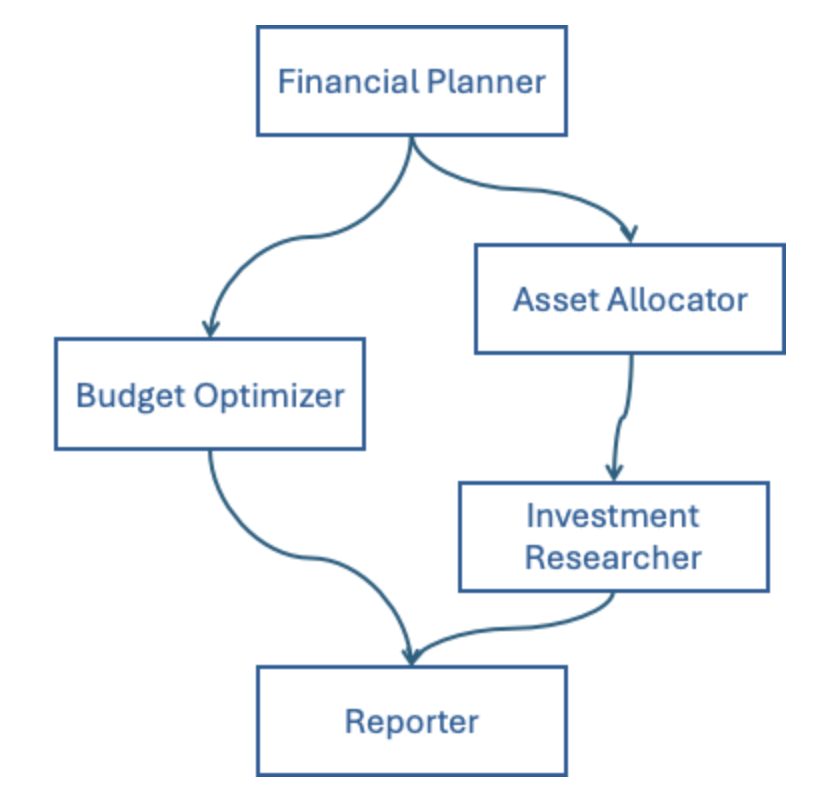

In [ ]:
from strands.multiagent import GraphBuilder

# Additional agent for reporting
reporter = Agent(model=model, system_prompt="Create a financial planning report based on the input.")

# Build the graph
builder = GraphBuilder()

# Add nodes
builder.add_node(financial_planner, "financial_planner")
builder.add_node(investment_researcher, "investment_researcher")
builder.add_node(budget_optimizer, "budget_optimizer")
builder.add_node(asset_allocator, "asset_allocator")
builder.add_node(reporter, "reporter")

# Add edges (dependencies)
builder.add_edge("financial_planner", "asset_allocator")
builder.add_edge("financial_planner", "budget_optimizer")
builder.add_edge("asset_allocator", "investment_researcher")
builder.add_edge("budget_optimizer", "reporter")
builder.add_edge("investment_researcher", "reporter")

# Set entry points (optional - will be auto-detected if not specified)
builder.set_entry_point("financial_planner")

# Build the graph
graph = builder.build()

# Execute the graph on a task
result = graph(
"""
    I'm 30 years old, earning around $6,000 per month.
    I have some student loans and moderate savings.
    I want to understand how I can better manage my monthly budget,
    explore investment options, and build a solid long-term financial plan
    for buying a house and retiring early. Can you help?
"""
)

# Access the results
print(f"\nStatus: {result.status}")
print(f"Execution order: {[node.node_id for node in result.execution_order]}")